# Emotion detection using a pre-trained model


In [1]:
import pandas as pd, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
import os, sys, librosa

# for loading scaler files
from joblib import load

# to plot and visualise information
from matplotlib import pyplot 
from IPython.display import Audio

##  Audio feature extractor functions

To run inference calculations on audio samples, and thus extract emotion probabilities, we need to first extract waveform features that represent the inputted sound.

The following features need to be computed: 

1. zero-crossing rate
2. chromagram 
3. mel-frequency cepstral coefficients 
4. root mean square values
5. mel spectogram

In the cell below are the functions to do just that.

In [2]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) 
    
    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) 

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) 
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    return result


## Function for returning a list of probabilities given an audio sample (.wav format)

In [3]:
def analyse_emotion(wav_path, data_scaler, classifier):
  if not(os.path.isfile(wav_path)):
    raise ValueError("error loading " + wav_path)

  # extract audio features 
  audio_features = np.asarray([get_features(wav_path)])

  # scale audio features using the original scaler fitted to training data
  scaled_audio = data_scaler.transform(audio_features)

  # return probabilities  
  return classifier.predict(scaled_audio)[0];

## Loading necessary files

`speech_classifier_path` represents the path to the pre-trained speech classifier. The filename should have an extension of ".h5".

`data_scaler` represents the path to the data scaler. It should end in ".bin".



In [4]:
speech_classifier_path = "speech_classifier.h5"
data_scaler_path = "std_scaler.bin"

model  = tf.keras.models.load_model(speech_classifier_path)
data_scaler = load(data_scaler_path)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


## Testing 

For testing purposes, change `wave_path_to_load` to whatever wave file you would like to test. Then run each cell sequentially.

**Test 1. Classifying Angry Voice**

In [5]:
emotion_mapper = {0:"angry", 1:"calm", 2:"disgust", 3:"fear", 4:"happy", 5:"neutral", 6:"sad", 7:"surpise"}
wave_path_to_load = "angry.wav"
Audio(wave_path_to_load)

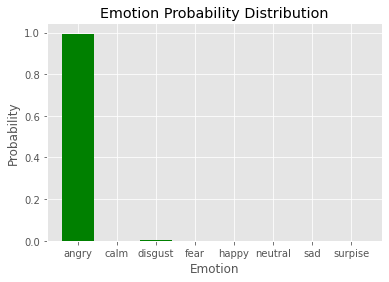

In [6]:
plt.style.use('ggplot')

probabilities = analyse_emotion(wave_path_to_load, data_scaler, model)

plt.bar(
    [emotion_mapper[i] for i in range(0,8)]
    , 
    probabilities
    , 
    color='green'
)
plt.xlabel("Emotion")
plt.ylabel("Probability")
plt.title("Emotion Probability Distribution")
plt.show()

**Test 2. Classifying mixed, hysterical voice that sounds both sad and bit angry**


In [7]:
wave_path_to_load = "mixed.wav"
Audio(wave_path_to_load)

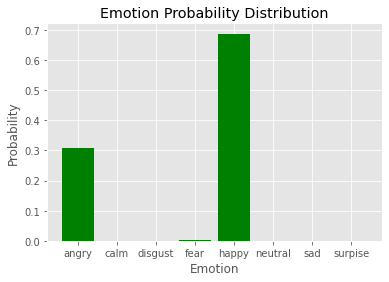

In [8]:
probabilities = analyse_emotion(wave_path_to_load, data_scaler, model)

plt.bar(
    [emotion_mapper[i] for i in range(0,8)]
    , 
    probabilities
    , 
    color='green'
)
plt.xlabel("Emotion")
plt.ylabel("Probability")
plt.title("Emotion Probability Distribution")
plt.show()

## Final thoughts 

In the future I will try to fine-tune this model to see if its accuracy on unseen data could be increased from 61%.